<h1>Data collection </h1>
Ten datasets were collected in total, taken from the Macau Open Data Platform https://data.gov.mo/Datasets
<br>They are "per capita consumption of overnight travelers", "total consumption of travelers", "per capita consumption of non overnight travelers", "inbound travelers", "overnight travelers", "non overnight travelers",
Average occupancy rate of hotels and apartments, individual travelers from mainland China, average length of stay for guests, and average length of stay for travelers.
<br>The time span for total passenger consumption, per capita consumption of overnight travelers, and per capita consumption of non overnight travelers is calculated quarterly, while the rest is calculated monthly.


Simulate mouse operations using selenuim. Reproduce this experiment without modifying any parameters, just have the necessary library

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json
from selenium.webdriver.chrome.options import Options
import os
import time
import urllib.parse


def get_default_download_path():
    """获取系统默认的下载路径"""
    if os.name == 'nt':  # Windows
        return os.path.join(os.environ['USERPROFILE'], 'Downloads')
    else:  # macOS and Linux
        return os.path.join(os.path.expanduser('~'), 'Downloads')

def download_file_by_keyword(keyword):
    # 获取默认下载路径
    download_dir = get_default_download_path()
    
    # 检查并创建下载目录（如果不存在）
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    # 设置性能日志记录的参数
    chrome_options = Options()
    chrome_options.set_capability('goog:loggingPrefs', {'performance': 'ALL'})
    
    # 设置下载目录
    prefs = {"download.default_directory": download_dir}
    chrome_options.add_experimental_option("prefs", prefs)

    # 初始化 WebDriver
    driver = webdriver.Chrome(options=chrome_options)

    # 目标URL
    url = "https://data.gov.mo/Datasets"

    # 打开网页
    driver.get(url)

    # 等待页面加载
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='root']/div/div[1]/div/div[2]/ul/li[8]"))
    )
    
    # 等到语言下拉框页面加载完成
    dropdown_trigger = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//*[@id='root']/div/div[1]/div/div[2]/ul/li[8]"))
    )
    dropdown_trigger.click()
    simplified_chinese_item = WebDriverWait(driver, 10).until(
        EC.visibility_of_element_located((By.XPATH, "/html/body/div[2]/div/div/ul/li[2]"))
    )

# 点击简体中文项
    simplified_chinese_item.click()
    time.sleep(2)

    # 找到搜索框并输入搜索关键词
    search_box = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, "/html/body/div[1]/div/div[2]/div[3]/div/div[2]/div/div[1]/span/span/span[1]/input"))
    )
    search_box.send_keys(keyword)
    time.sleep(2)
    
    # 点击搜索按钮
    search_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "/html/body/div/div/div[2]/div[3]/div/div[2]/div/div[1]/span/span/span[2]/button"))
    )
    search_button.click()


    # 等待搜索结果加载，特别是等待包含关键词的文本出现
    dataset_link = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, f"//a[text()='{keyword}']"))
    )

    # 获取href属性的值
    href_value = dataset_link.get_attribute('href')
    # 打印href值
    print(href_value)
    driver.get(href_value)

#     dataset_link.click()

    # 等待元素可点击
    download_icon = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//*[@id='root']/div/div[2]/div[2]/div/div/div[5]/div/div/ul/li/div/div[2]/div/span[3]/a"))
    )
    download_icon.click()

    # 获取所有网络请求
    logs = driver.get_log('performance')

    # 解析日志以找到下载请求
    request_id = None
    for entry in logs:
        log = json.loads(entry['message'])['message']
        if log['method'] == 'Network.requestWillBeSent':
            load_url = log['params']['request']['url']
            if "datadir/downloadSingleFile" in load_url:
                print(f"Correct Request URL: {load_url}")
                request_id = log['params']['requestId']
                break

    # 解析日志以找到下载请求的文件名
    if request_id:
        for entry in logs:
            log = json.loads(entry['message'])['message']
            if log['method'] == 'Network.responseReceived' and log['params']['requestId'] == request_id:
                headers = log['params']['response']['headers']
                if 'Content-Disposition' in headers:
                    content_disposition = headers['Content-Disposition']
                    # 对文件名称进行解码，主要问题为averageOccupancyRateOfHotels%26Guesthouses
                    filename = urllib.parse.unquote(content_disposition.split('filename=')[1].split(';')[0].strip('"'))
                    print(f"Filename: {filename.split('.')[0]}")
                    print(f"Download Path: {os.path.join(download_dir, filename)}")
                    # 检查文件是否下载完成
                    while not os.path.exists(os.path.join(download_dir, filename)):
                        time.sleep(1)  # 等待一秒钟再检查下载目录
                    
                    break
# 对文件名称进行解码，主要问题为averageOccupancyRateOfHotels%26Guesthouses


    
    print('下载成功')
    driver.quit()
    return filename, download_dir


# # 或使用requests库发送请求
# response = requests.get(load_url, stream=True)
# # 从响应头中获取Content-Disposition
# content_disposition = response.headers.get('Content-Disposition')

# # 提取文件名
# if content_disposition:
#     filename = content_disposition.split('filename=')[1].split(';')[0].strip('"')
#     print(f"文件名: {filename}")
# else:
#     print("未找到文件名")
#     driver.quit()


# 示例调用函数，关键词为“入境旅客”
# download_file_by_keyword("旅客总消费")


In [2]:
# 关键词列表
keywords = [
    "留宿旅客人均消费", "旅客总消费", "不过夜旅客人均消费", "入境旅客", "留宿旅客", "不过夜旅客",
    "酒店及公寓平均入住率", "中国内地个人游旅客", "住客平均留宿时间", "旅客平均逗留时间"
]
file_paths = {}
# 循环调用函数
for keyword in keywords:
    print('数据集为',keyword)
    filename, download_dir = download_file_by_keyword(keyword)
    if filename:
        file_paths[filename.split('.')[0]] = os.path.join(download_dir, filename)
print('文件的名称及路径',file_paths)


数据集为 留宿旅客人均消费
https://data.gov.mo/Detail?id=551464b2-6cf6-43b0-9dfb-5f21cf94a04d
Correct Request URL: https://api.data.gov.mo/datadir/downloadSingleFile?fileId=885&dataDirId=551464b2-6cf6-43b0-9dfb-5f21cf94a04d&token=Z3m1jDj8WjtRqAxMLIYPHBF8MG4VSW9N
Filename: percapitaSpendingOfOvernightVisitors
Download Path: C:\Users\Hasee\Downloads\percapitaSpendingOfOvernightVisitors.xlsx
下载成功
数据集为 旅客总消费
https://data.gov.mo/Detail?id=6466a42d-cd30-40a3-9017-3e0066e6b077
Correct Request URL: https://api.data.gov.mo/datadir/downloadSingleFile?fileId=842&dataDirId=6466a42d-cd30-40a3-9017-3e0066e6b077&token=7QijyeGFYPROmIBhUZllFeimjUYPsQhZr
Filename: totalSpendingOfVisitors
Download Path: C:\Users\Hasee\Downloads\totalSpendingOfVisitors.xlsx
下载成功
数据集为 不过夜旅客人均消费
https://data.gov.mo/Detail?id=0c9fa128-2979-476e-a6d0-0516e917c90d
Correct Request URL: https://api.data.gov.mo/datadir/downloadSingleFile?fileId=886&dataDirId=0c9fa128-2979-476e-a6d0-0516e917c90d&token=bcXO4avxrqPic7YW5UqWeI2afSmrwRh5J
Filename

In [3]:
print("数据集文件名:地址")
for name, path in file_paths.items():
    print(f'{name}: {path}')


数据集文件名:地址
percapitaSpendingOfOvernightVisitors: C:\Users\Hasee\Downloads\percapitaSpendingOfOvernightVisitors.xlsx
totalSpendingOfVisitors: C:\Users\Hasee\Downloads\totalSpendingOfVisitors.xlsx
percapitaSpendingOfSameDayVisitors: C:\Users\Hasee\Downloads\percapitaSpendingOfSameDayVisitors.xlsx
visitorArrivals: C:\Users\Hasee\Downloads\visitorArrivals.xlsx
overnightVisitor: C:\Users\Hasee\Downloads\overnightVisitor.xlsx
sameDayVisitor: C:\Users\Hasee\Downloads\sameDayVisitor.xlsx
averageOccupancyRateOfHotels&Guesthouses: C:\Users\Hasee\Downloads\averageOccupancyRateOfHotels&Guesthouses.xlsx
mainlandVisitorsUnderIndividualVisitScheme: C:\Users\Hasee\Downloads\mainlandVisitorsUnderIndividualVisitScheme.xlsx
averageLengthOfStayOfGuests: C:\Users\Hasee\Downloads\averageLengthOfStayOfGuests.xlsx
averageLengthOfStayOfVisitors: C:\Users\Hasee\Downloads\averageLengthOfStayOfVisitors.xlsx


In [5]:
import pandas as pd

# 使用字典存储变量
data_frames = {}

# 动态创建变量并读取 Excel 文件
for keyword, file_path in file_paths.items():
    variable_name = keyword.replace(" ", "_")
    try:
        data_frames[variable_name] = pd.read_excel(file_path)
    except FileNotFoundError as e:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")
#验证数据集是否存在
for variable_name, df in data_frames.items():
    print(f"Content of {variable_name}:")
    print(df)

Content of percapitaSpendingOfOvernightVisitors:
      period value
0      2023年  4230
1      2022年  6004
2      2021年  5767
3      2020年  3468
4      2019年  2681
..       ...   ...
67  2011年第一季  2623
68  2010年第四季  2874
69  2010年第三季  2558
70  2010年第二季  2381
71  2010年第一季  2294

[72 rows x 2 columns]
Content of totalSpendingOfVisitors:
      period  value
0      2023年  71245
1      2022年  18165
2      2021年  24453
3      2020年  11938
4      2019年  64077
..       ...    ...
67  2011年第一季   9751
68  2010年第四季  10723
69  2010年第三季   9722
70  2010年第二季   8779
71  2010年第一季   8668

[72 rows x 2 columns]
Content of percapitaSpendingOfSameDayVisitors:
      period value
0      2023年   791
1      2022年  1011
2      2021年   782
3      2020年   700
4      2019年   680
..       ...   ...
67  2011年第一季   600
68  2010年第四季   619
69  2010年第三季   585
70  2010年第二季   557
71  2010年第一季   609

[72 rows x 2 columns]
Content of visitorArrivals:
      period     value
0      2023年  28213003
1      2022年   5700339
2     

<h1>Data processing</h1>

In [6]:
# 加载10个数据集，并分别概览
import pandas as pd

# 加载数据集
total_consumption = pd.read_excel(file_paths["totalSpendingOfVisitors"])
average_consumption_staying = pd.read_excel(file_paths["percapitaSpendingOfOvernightVisitors"])
average_consumption_non_staying = pd.read_excel(file_paths["percapitaSpendingOfSameDayVisitors"])
inbound_tourists = pd.read_excel(file_paths["visitorArrivals"])
staying_tourists = pd.read_excel(file_paths["overnightVisitor"])
non_staying_tourists = pd.read_excel(file_paths["sameDayVisitor"])
hotel_occupancy_rate = pd.read_excel(file_paths["averageOccupancyRateOfHotels&Guesthouses"])
mainland_individual_vistors = pd.read_excel(file_paths["mainlandVisitorsUnderIndividualVisitScheme"])
average_length_of_staying_tourists = pd.read_excel(file_paths["averageLengthOfStayOfGuests"])
average_length_of_tourists = pd.read_excel(file_paths["averageLengthOfStayOfVisitors"])



# 显示每个数据集的前几行
print("旅客总消费:")
print(total_consumption, "\n")

print("留宿旅客人均消费:")
print(average_consumption_non_staying, "\n")

print("不过夜旅客人均消费:")
print(average_consumption_non_staying, "\n")

print("入境旅客:")
print(inbound_tourists, "\n")

print("留宿旅客:")
print(staying_tourists, "\n")

print("不过夜旅客:")
print(non_staying_tourists, "\n")

print("酒店及公寓的平均入住率:")
print(hotel_occupancy_rate, "\n")

print("中国内地个人旅游客:")
print(mainland_individual_vistors, "\n")

print("住客平均留宿时间:")
print(average_length_of_staying_tourists, "\n")

print("旅客平均逗留时间:")
print(average_length_of_tourists, "\n")


旅客总消费:
      period  value
0      2023年  71245
1      2022年  18165
2      2021年  24453
3      2020年  11938
4      2019年  64077
..       ...    ...
67  2011年第一季   9751
68  2010年第四季  10723
69  2010年第三季   9722
70  2010年第二季   8779
71  2010年第一季   8668

[72 rows x 2 columns] 

留宿旅客人均消费:
      period value
0      2023年   791
1      2022年  1011
2      2021年   782
3      2020年   700
4      2019年   680
..       ...   ...
67  2011年第一季   600
68  2010年第四季   619
69  2010年第三季   585
70  2010年第二季   557
71  2010年第一季   609

[72 rows x 2 columns] 

不过夜旅客人均消费:
      period value
0      2023年   791
1      2022年  1011
2      2021年   782
3      2020年   700
4      2019年   680
..       ...   ...
67  2011年第一季   600
68  2010年第四季   619
69  2010年第三季   585
70  2010年第二季   557
71  2010年第一季   609

[72 rows x 2 columns] 

入境旅客:
      period     value
0      2023年  28213003
1      2022年   5700339
2      2021年   7705943
3      2020年   5896848
4      2019年  39406181
..       ...       ...
210  2008年5月   2000282
211  2008年4

**Now I need to perform data processing to create an integrated training set**

In [7]:
# 创建时间索引
index = [f"{year}年第{quarter}季" for year in range(2010, 2025) for quarter in ["一", "二", "三", "四"]]
index = index[:len(pd.date_range(start='2010Q1', end='2024Q3', freq='QE'))]
# 创建空的DataFrame
df = pd.DataFrame(index=index)
# 提取并添加数据到DataFrame中
df['旅客总消费'] = total_consumption.set_index('period').reindex(index)['value']
df['留宿旅客人均消费'] = average_consumption_staying.set_index('period').reindex(index)['value']
df['不过夜旅客人均消费'] = average_consumption_non_staying.set_index('period').reindex(index)['value']
df

,旅客总消费,留宿旅客人均消费,不过夜旅客人均消费
2010年第一季,8668,2294,609
2010年第二季,8779,2381,557
2010年第三季,9722,2558,585
2010年第四季,10723,2874,619
2011年第一季,9751,2623,600
2011年第二季,10102,2502,609
2011年第三季,12112,2716,647
2011年第四季,13362,3234,643
2012年第一季,13131,3358,665
2012年第二季,11366,2895,594


In [8]:
# 重新命名索引
df.index = df.index.str.replace('第一季', '第1季')
df.index = df.index.str.replace('第二季', '第2季')
df.index = df.index.str.replace('第三季', '第3季')
df.index = df.index.str.replace('第四季', '第4季')
df.index.name = 'period'
# 显示结果
print(df)

          旅客总消费 留宿旅客人均消费 不过夜旅客人均消费
period                            
2010年第1季   8668     2294       609
2010年第2季   8779     2381       557
2010年第3季   9722     2558       585
2010年第4季  10723     2874       619
2011年第1季   9751     2623       600
2011年第2季  10102     2502       609
2011年第3季  12112     2716       647
2011年第4季  13362     3234       643
2012年第1季  13131     3358       665
2012年第2季  11366     2895       594
2012年第3季  13274     3081       549
2012年第4季  14575     3573       534
2013年第1季  14479     3574       632
2013年第2季  13940     3396       614
2013年第3季  14803     3179       650
2013年第4季  16318     3776       746
2014年第1季  15948     3691       673
2014年第2季  16261     3915       610
2014年第3季  15486     3310       599
2014年第4季  14054     3082       679
2015年第1季  13359     3230       706
2015年第2季  12251     2820       676
2015年第3季  12467     2519       632
2015年第4季  13051     2733       658
2016年第1季  11540     2525       679
2016年第2季  11697     2543       658
2016年第3季  14636     

In [9]:

# 将 period 列转换为标准日期格式
inbound_tourists['period'] = pd.to_datetime(inbound_tourists['period'], format='%Y年%m月', errors='coerce')
staying_tourists['period'] = pd.to_datetime(staying_tourists['period'], format='%Y年%m月', errors='coerce')
non_staying_tourists['period'] = pd.to_datetime(non_staying_tourists['period'], format='%Y年%m月', errors='coerce')
hotel_occupancy_rate['period'] = pd.to_datetime(hotel_occupancy_rate['period'], format='%Y年%m月', errors='coerce')
mainland_individual_vistors['period'] =  pd.to_datetime(mainland_individual_vistors['period'], format='%Y年%m月', errors='coerce')
average_length_of_staying_tourists['period'] =  pd.to_datetime(average_length_of_staying_tourists['period'], format='%Y年%m月', errors='coerce')
average_length_of_tourists['period'] =  pd.to_datetime(average_length_of_tourists['period'], format='%Y年%m月', errors='coerce')


In [10]:
# 提取2010年1月到2024年6月的数据
inbound_tourists = inbound_tourists.loc[(inbound_tourists['period'] >= '2010-01-01') & (inbound_tourists['period'] <= '2024-06-30')]
staying_tourists = staying_tourists.loc[(staying_tourists['period'] >= '2010-01-01') & (staying_tourists['period'] <= '2024-06-30')]
non_staying_tourists = non_staying_tourists.loc[(non_staying_tourists['period'] >= '2010-01-01') & (non_staying_tourists['period'] <= '2024-06-30')]
hotel_occupancy_rate = hotel_occupancy_rate.loc[(hotel_occupancy_rate['period'] >= '2010-01-01') & (hotel_occupancy_rate['period'] <= '2024-06-30')]
mainland_individual_vistors = mainland_individual_vistors.loc[(mainland_individual_vistors['period'] >= '2010-01-01') & (mainland_individual_vistors['period'] <= '2024-06-30')]
average_length_of_staying_tourists = average_length_of_staying_tourists.loc[(average_length_of_staying_tourists['period'] >= '2010-01-01') & (average_length_of_staying_tourists['period'] <= '2024-06-30')]
average_length_of_tourists = average_length_of_tourists.loc[(average_length_of_tourists['period'] >= '2010-01-01') & (average_length_of_tourists['period'] <= '2024-06-30')]



In [11]:
# 将月份数据转换为季度数据
inbound_tourists.set_index('period', inplace=True)
staying_tourists.set_index('period', inplace=True)
non_staying_tourists.set_index('period', inplace=True)
hotel_occupancy_rate.set_index('period', inplace=True)
mainland_individual_vistors.set_index('period', inplace=True)
average_length_of_staying_tourists.set_index('period', inplace=True)
average_length_of_tourists.set_index('period', inplace=True)


inbound_tourists_quarterly = inbound_tourists.resample('QE').sum()
staying_tourists_quarterly = staying_tourists.resample('QE').sum()
non_staying_tourists_quarterly = non_staying_tourists.resample('QE').sum()
hotel_occupancy_rate_quarterly = hotel_occupancy_rate.resample('QE').mean()
mainland_individual_vistors_quarterly = mainland_individual_vistors.resample('QE').sum()
average_length_of_staying_tourists_quarterly = average_length_of_staying_tourists.resample('QE').sum()
average_length_of_tourists_quarterly = average_length_of_tourists.resample('QE').sum()


# 显示结果
print("入境旅客（季度）:")
print(inbound_tourists_quarterly, "\n")

print("留宿旅客（季度）:")
print(staying_tourists_quarterly, "\n")

print("不过夜旅客（季度）:")
print(non_staying_tourists_quarterly, "\n")

print("酒店及公寓的平均入住率（季度）:")
print(hotel_occupancy_rate_quarterly, "\n")

print("中国内地个人旅游客（季度）:")
print(mainland_individual_vistors_quarterly, "\n")

print("住客平均留宿时间（季度）:")
print(average_length_of_staying_tourists_quarterly, "\n")

print("旅客平均逗留时间（季度）:")
print(average_length_of_tourists_quarterly, "\n")



入境旅客（季度）:
               value
period              
2010-03-31   6115221
2010-06-30   6114225
2010-09-30   6359133
2010-12-31   6376832
2011-03-31   6431180
2011-06-30   6815476
2011-09-30   7415497
2011-12-31   7340126
2012-03-31   6942320
2012-06-30   6635394
2012-09-30   7286971
2012-12-31   7217607
2013-03-31   7076442
2013-06-30   7065798
2013-09-30   7768583
2013-12-31   7413999
2014-03-31   7690166
2014-06-30   7593681
2014-09-30   8245162
2014-12-31   7996623
2015-03-31   7412221
2015-06-30   7344278
2015-09-30   8097474
2015-12-31   7860655
2016-03-31   7457106
2016-06-30   7307190
2016-09-30   8104498
2016-12-31   8081542
2017-03-31   7872461
2017-06-30   7691842
2017-09-30   8270736
2017-12-31   8775467
2018-03-31   8545713
2018-06-30   8268477
2018-09-30   8999074
2018-12-31   9990399
2019-03-31  10359758
2019-06-30   9924875
2019-09-30   9918273
2019-12-31   9203275
2020-03-31   3219170
2020-06-30     49730
2020-09-30    750204
2020-12-31   1877744
2021-03-31   1738428
202

In [12]:
# 将季度数据的索引转换为df季度格式
def convert_to_chinese_quarterly_index(df):
    df.index = df.index.to_period('Q').strftime('%Y年第%q季')
    return df

inbound_tourists_quarterly = convert_to_chinese_quarterly_index(inbound_tourists_quarterly)
staying_tourists_quarterly = convert_to_chinese_quarterly_index(staying_tourists_quarterly)
non_staying_tourists_quarterly = convert_to_chinese_quarterly_index(non_staying_tourists_quarterly)
hotel_occupancy_rate_quarterly = convert_to_chinese_quarterly_index(hotel_occupancy_rate_quarterly)
mainland_individual_vistors_quarterly = convert_to_chinese_quarterly_index(mainland_individual_vistors_quarterly)
average_length_of_staying_tourists_quarterly = convert_to_chinese_quarterly_index(average_length_of_staying_tourists_quarterly)
average_length_of_tourists_quarterly = convert_to_chinese_quarterly_index(average_length_of_tourists_quarterly)


In [13]:
# 将季度数据添加到DataFrame中，并确保索引匹配
df['入境旅客'] = inbound_tourists_quarterly['value']
df['留宿旅客'] = staying_tourists_quarterly['value']
df['不过夜旅客'] = non_staying_tourists_quarterly['value']
df['酒店及公寓的平均入住率'] = hotel_occupancy_rate_quarterly['value']
df['中国内地个人旅游客'] = mainland_individual_vistors_quarterly['value']
df['住客平均留宿时间'] = average_length_of_staying_tourists_quarterly['value']
df['旅客平均逗留时间'] = average_length_of_tourists_quarterly['value']



In [14]:
missing_count = df.isnull().sum()

# 打印每列中的缺失值数量
print("\n每列中的缺失值数量:")
print(missing_count)
df


每列中的缺失值数量:
旅客总消费          0
留宿旅客人均消费       0
不过夜旅客人均消费      0
入境旅客           0
留宿旅客           0
不过夜旅客          0
酒店及公寓的平均入住率    0
中国内地个人旅游客      0
住客平均留宿时间       0
旅客平均逗留时间       4
dtype: int64


,旅客总消费,留宿旅客人均消费,不过夜旅客人均消费,入境旅客,留宿旅客,不过夜旅客,酒店及公寓的平均入住率,中国内地个人旅游客,住客平均留宿时间,旅客平均逗留时间
period,,,,,,,,,,
2010年第1季,8668,2294,609,6115221,2934361,3180860,79.100000,1448730,4.5,NaN
2010年第2季,8779,2381,557,6114225,2945677,3168548,78.200000,1217559,4.4,NaN
2010年第3季,9722,2558,585,6359133,3041503,3317630,78.833333,1408426,4.5,NaN
2010年第4季,10723,2874,619,6376832,3004330,3372502,83.000000,1411458,4.3,NaN
2011年第1季,9751,2623,600,6431180,2912517,3518663,81.033333,1619997,4.5,3.1
2011年第2季,10102,2502,609,6815476,3143177,3672299,83.000000,1491809,4.3,3.2
2011年第3季,12112,2716,647,7415497,3534454,3881043,85.500000,1765314,4.3,3.1
2011年第4季,13362,3234,643,7340126,3335012,4005114,86.633333,1711602,4.6,2.7
2012年第1季,13131,3358,665,6942320,3161031,3781289,83.766667,1781446,4.3,2.7


In [15]:
import numpy as np
# 将所有'~'符号替换为NaN
df.replace('~ ', np.nan, inplace=True)
# # 使用后向填充缺失值
df.bfill(inplace=True)

for col in df.columns[:3]:
    df[col] = df[col].astype('Int64')
    
# 计算新的旅客总消费，统一单位
df['旅客总消费'] = df['留宿旅客人均消费'] * df['留宿旅客'] + df['不过夜旅客人均消费'] * df['不过夜旅客']

df

C:\Users\Hasee\AppData\Local\Temp\ipykernel_13812\1010710160.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('~ ', np.nan, inplace=True)


,旅客总消费,留宿旅客人均消费,不过夜旅客人均消费,入境旅客,留宿旅客,不过夜旅客,酒店及公寓的平均入住率,中国内地个人旅游客,住客平均留宿时间,旅客平均逗留时间
period,,,,,,,,,,
2010年第1季,8668567874,2294,609,6115221,2934361,3180860,79.100000,1448730,4.5,3.1
2010年第2季,8778538173,2381,557,6114225,2945677,3168548,78.200000,1217559,4.4,3.1
2010年第3季,9720978224,2558,585,6359133,3041503,3317630,78.833333,1408426,4.5,3.1
2010年第4季,10722023158,2874,619,6376832,3004330,3372502,83.000000,1411458,4.3,3.1
2011年第1季,9750729891,2623,600,6431180,2912517,3518663,81.033333,1619997,4.5,3.1
2011年第2季,10100658945,2502,609,6815476,3143177,3672299,83.000000,1491809,4.3,3.2
2011年第3季,12110611885,2716,647,7415497,3534454,3881043,85.500000,1765314,4.3,3.1
2011年第4季,13360717110,3234,643,7340126,3335012,4005114,86.633333,1711602,4.6,2.7
2012年第1季,13129299283,3358,665,6942320,3161031,3781289,83.766667,1781446,4.3,2.7


In [16]:
df['date'] = df.index
# 定义一个函数，将季度转换为年月日的形式
def quarter_to_date(quarter_str):
    year = int(quarter_str.split('年第')[0])
    quarter = int(quarter_str.split('年第')[1].split('季')[0])
    if quarter == 1:
        return f"{year}-03-31"
    elif quarter == 2:
        return f"{year}-06-30"
    elif quarter == 3:
        return f"{year}-09-30"
    elif quarter == 4:
        return f"{year}-12-31"

# 应用函数转换季度为年月日，并转换为时间戳
df['date'] = df['date'].apply(quarter_to_date)
df['release_date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
df['release_date'] = df['release_date'].astype('int64') // 10**9
df

,旅客总消费,留宿旅客人均消费,不过夜旅客人均消费,入境旅客,留宿旅客,不过夜旅客,酒店及公寓的平均入住率,中国内地个人旅游客,住客平均留宿时间,旅客平均逗留时间,date,release_date
period,,,,,,,,,,,,
2010年第1季,8668567874,2294,609,6115221,2934361,3180860,79.100000,1448730,4.5,3.1,2010-03-31,1269993600
2010年第2季,8778538173,2381,557,6114225,2945677,3168548,78.200000,1217559,4.4,3.1,2010-06-30,1277856000
2010年第3季,9720978224,2558,585,6359133,3041503,3317630,78.833333,1408426,4.5,3.1,2010-09-30,1285804800
2010年第4季,10722023158,2874,619,6376832,3004330,3372502,83.000000,1411458,4.3,3.1,2010-12-31,1293753600
2011年第1季,9750729891,2623,600,6431180,2912517,3518663,81.033333,1619997,4.5,3.1,2011-03-31,1301529600
2011年第2季,10100658945,2502,609,6815476,3143177,3672299,83.000000,1491809,4.3,3.2,2011-06-30,1309392000
2011年第3季,12110611885,2716,647,7415497,3534454,3881043,85.500000,1765314,4.3,3.1,2011-09-30,1317340800
2011年第4季,13360717110,3234,643,7340126,3335012,4005114,86.633333,1711602,4.6,2.7,2011-12-31,1325289600
2012年第1季,13129299283,3358,665,6942320,3161031,3781289,83.766667,1781446,4.3,2.7,2012-03-31,1333152000


In [17]:
# 统计每列中的缺失值数量
missing_count = df.isnull().sum()

# 打印每列中的缺失值数量
print("\n每列中的缺失值数量:")
print(missing_count)

print(df.head())  # 查看前几行数据
print(df.info())  # 获取数据类型和非空值信息
print(df.describe())  # 获取数值列的统计摘要


每列中的缺失值数量:
旅客总消费           0
留宿旅客人均消费        0
不过夜旅客人均消费       0
入境旅客            0
留宿旅客            0
不过夜旅客           0
酒店及公寓的平均入住率     0
中国内地个人旅游客       0
住客平均留宿时间        0
旅客平均逗留时间        0
date            0
release_date    0
dtype: int64
                旅客总消费  留宿旅客人均消费  不过夜旅客人均消费     入境旅客     留宿旅客    不过夜旅客  \
period                                                                  
2010年第1季   8668567874      2294        609  6115221  2934361  3180860   
2010年第2季   8778538173      2381        557  6114225  2945677  3168548   
2010年第3季   9720978224      2558        585  6359133  3041503  3317630   
2010年第4季  10722023158      2874        619  6376832  3004330  3372502   
2011年第1季   9750729891      2623        600  6431180  2912517  3518663   

          酒店及公寓的平均入住率  中国内地个人旅游客  住客平均留宿时间  旅客平均逗留时间        date  release_date  
period                                                                          
2010年第1季    79.100000    1448730       4.5       3.1  2010-03-31    1269993600  
2010

<h1>Data analysis and visualizations</h1>

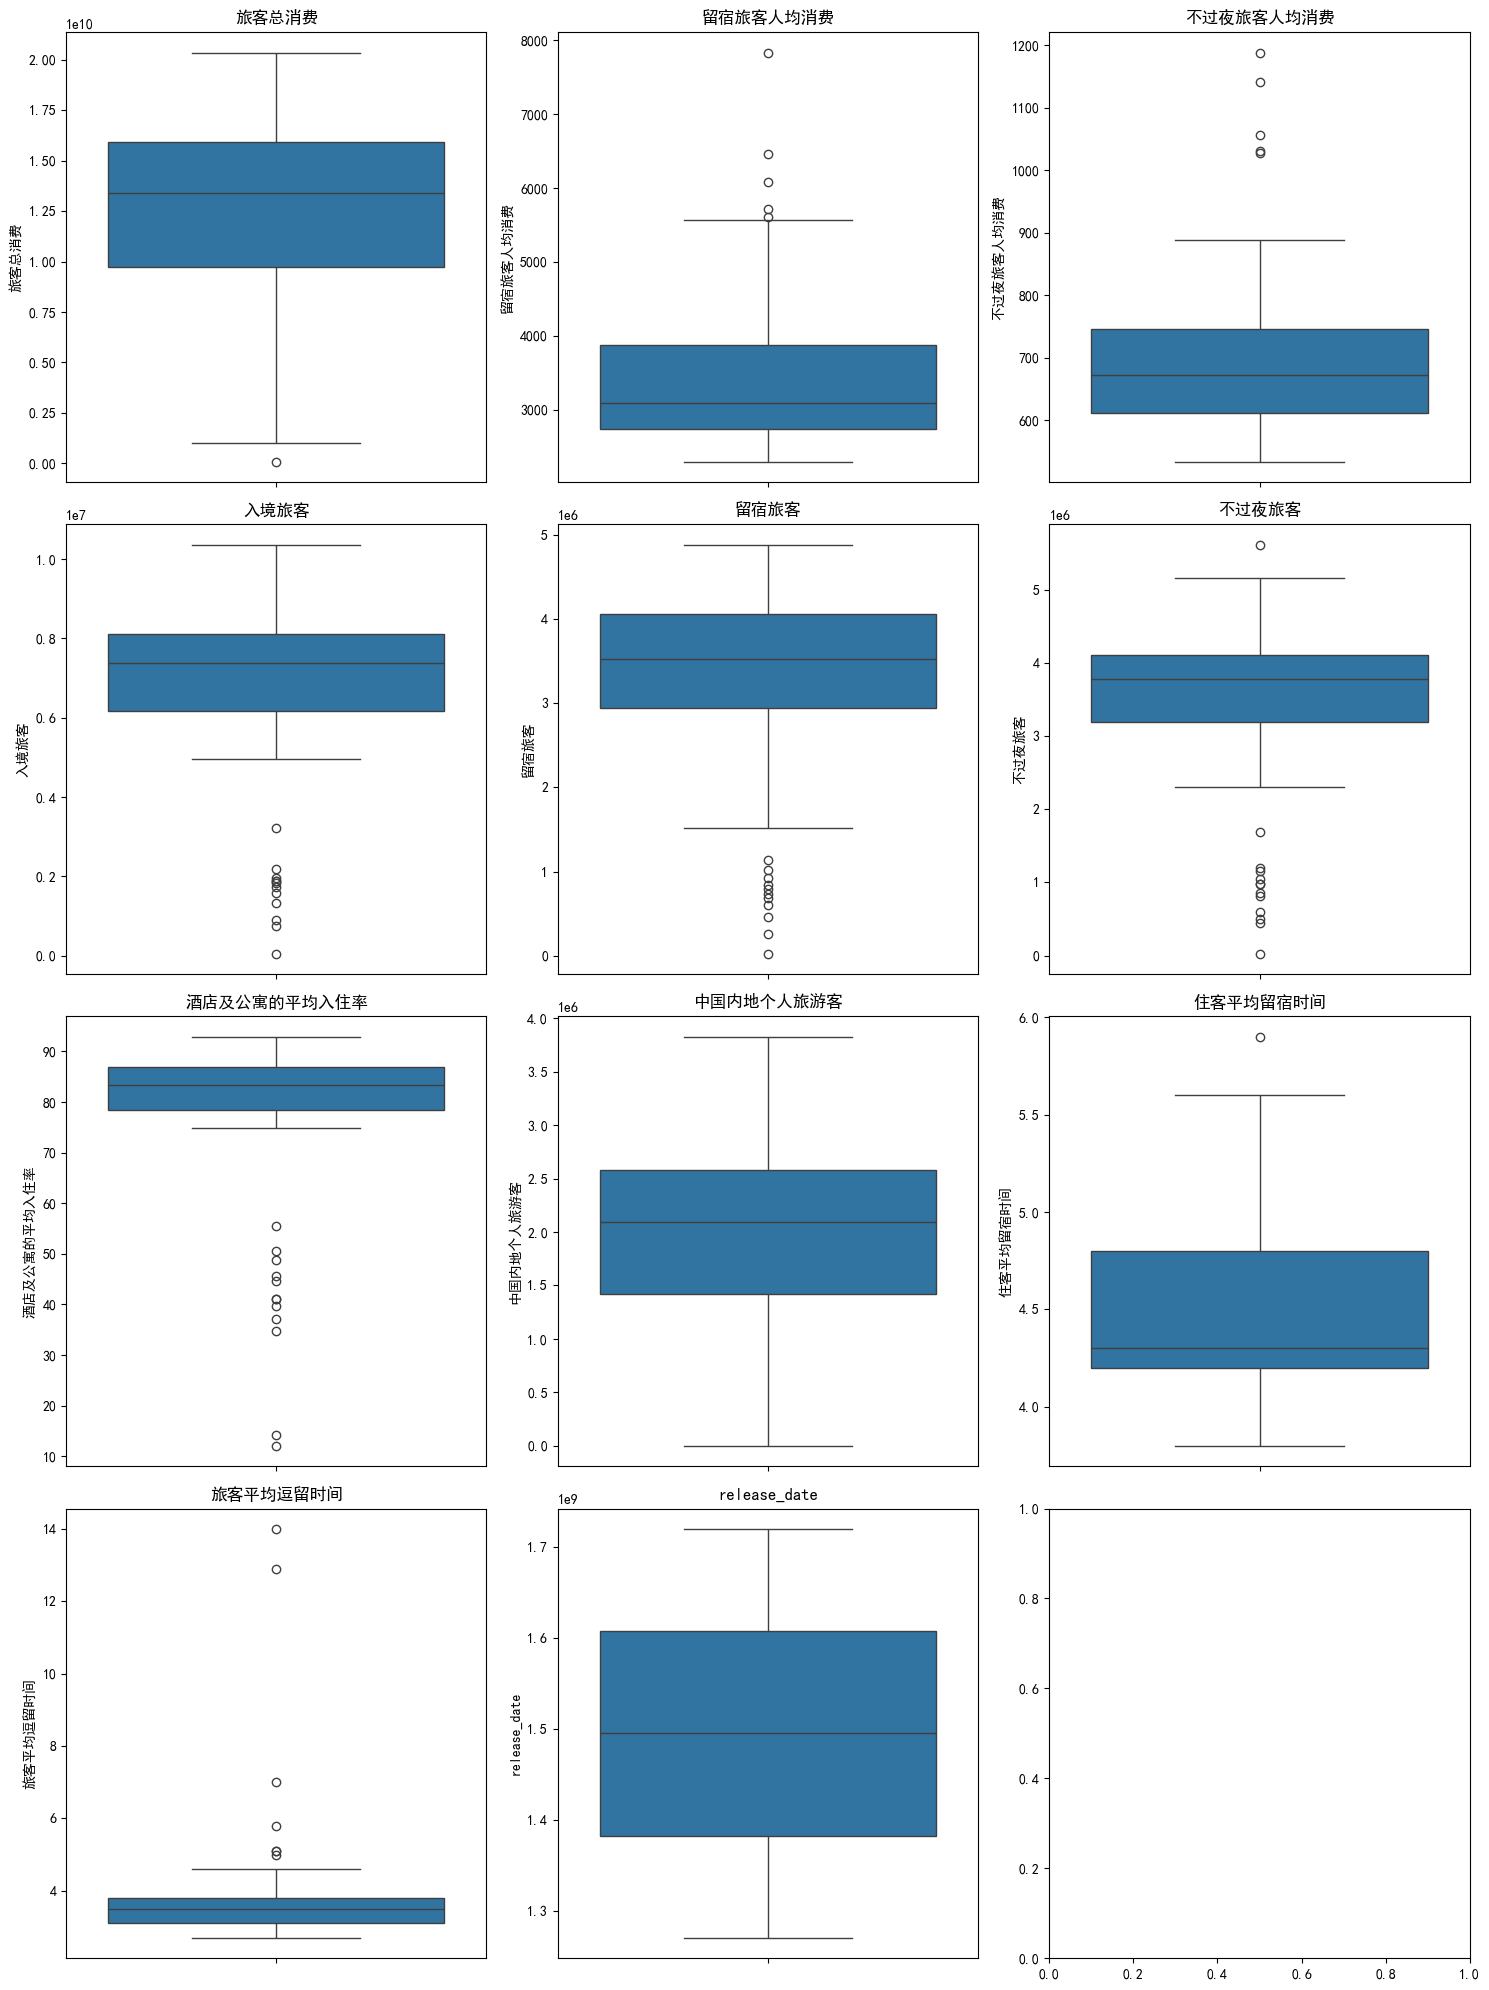

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题
# 选择数值列
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# 创建一个4行3列的图形网格
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))  # 调整figsize以适应你的显示需求

# 遍历每个变量，绘制箱线图
for i, col in enumerate(numeric_cols):
    row = i // 3  # 计算行号
    col_index = i % 3  # 计算列号
    sns.boxplot(y=df[col], ax=axes[row, col_index])  # 在对应的子图中绘制箱线图
    axes[row, col_index].set_title(col)  # 设置子图标题

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

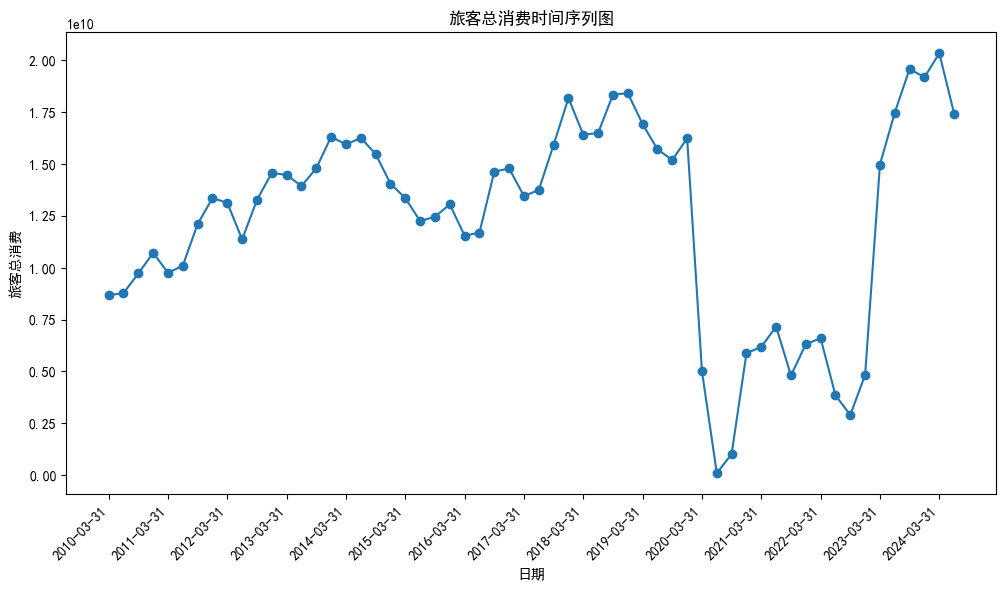

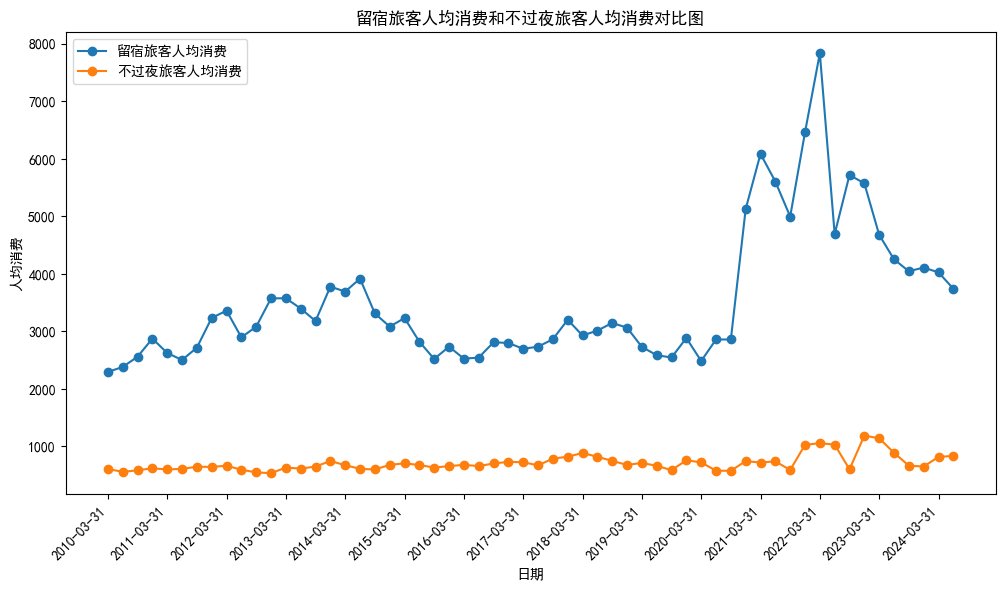

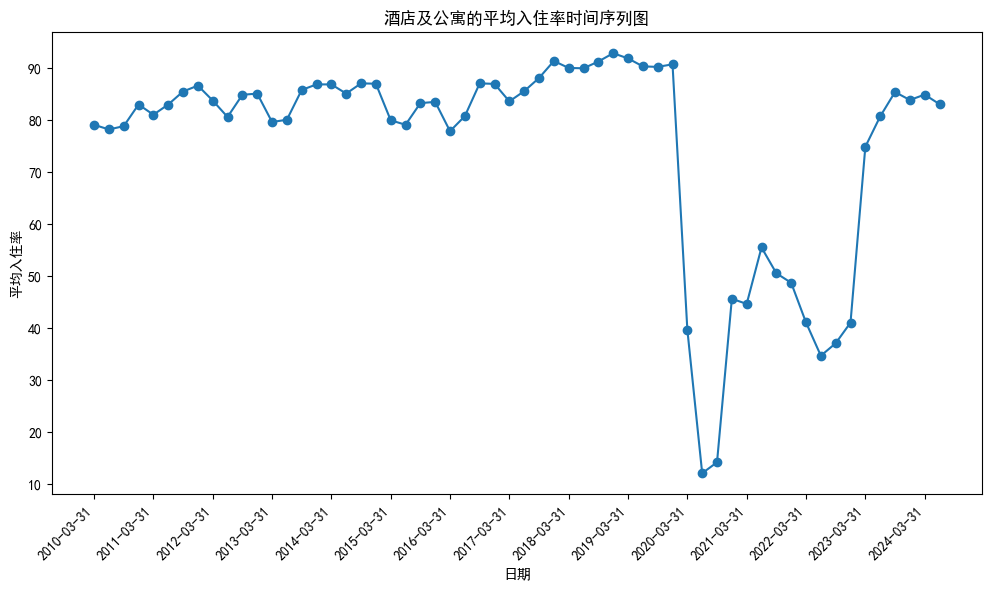

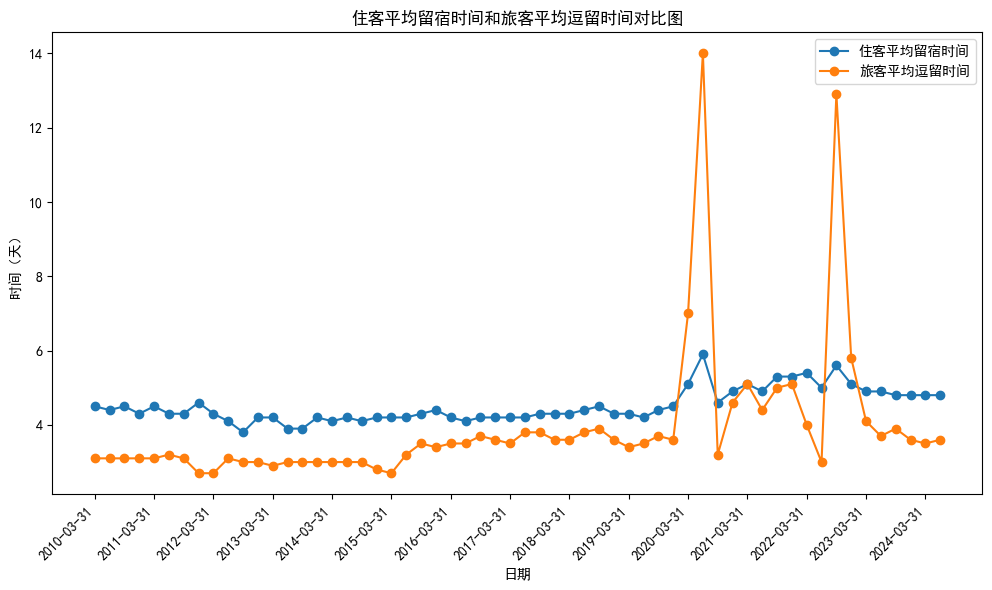

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

# 绘制旅客总消费的时间序列图
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['旅客总消费'], marker='o')
plt.title('旅客总消费时间序列图')
plt.xlabel('日期')
plt.ylabel('旅客总消费')
plt.xticks(df['date'][::4], rotation=45, ha='right')  # X轴设置间隔为三个季度
plt.grid(False)  
plt.show()

# 绘制留宿旅客人均消费和不过夜旅客人均消费的对比图
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['留宿旅客人均消费'], marker='o', label='留宿旅客人均消费')
plt.plot(df['date'], df['不过夜旅客人均消费'], marker='o', label='不过夜旅客人均消费')
plt.title('留宿旅客人均消费和不过夜旅客人均消费对比图')
plt.xlabel('日期')
plt.ylabel('人均消费')
plt.legend()
plt.xticks(df['date'][::4], rotation=45, ha='right')  # X轴设置间隔为三个季度
plt.grid(False)
plt.show()

# 绘制酒店及公寓的平均入住率的时间序列图
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['酒店及公寓的平均入住率'], marker='o')
plt.title('酒店及公寓的平均入住率时间序列图')
plt.xlabel('日期')
plt.ylabel('平均入住率')
plt.xticks(df['date'][::4], rotation=45, ha='right')  # X轴设置间隔为三个季度
plt.grid(False)  
plt.show()

# 绘制住客平均留宿时间和旅客平均逗留时间的对比图
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['住客平均留宿时间'], marker='o', label='住客平均留宿时间')
plt.plot(df['date'], df['旅客平均逗留时间'], marker='o', label='旅客平均逗留时间')
plt.title('住客平均留宿时间和旅客平均逗留时间对比图')
plt.xlabel('日期')
plt.ylabel('时间（天）')
plt.legend()
plt.xticks(df['date'][::4], rotation=45, ha='right')  # X轴设置间隔为三个季度
plt.grid(False) 
plt.show()


**The following is a dynamic interactive PCA graph and a static PCA graph
<br>The dynamic part needs to be reloaded**

Loading BokehJS ...

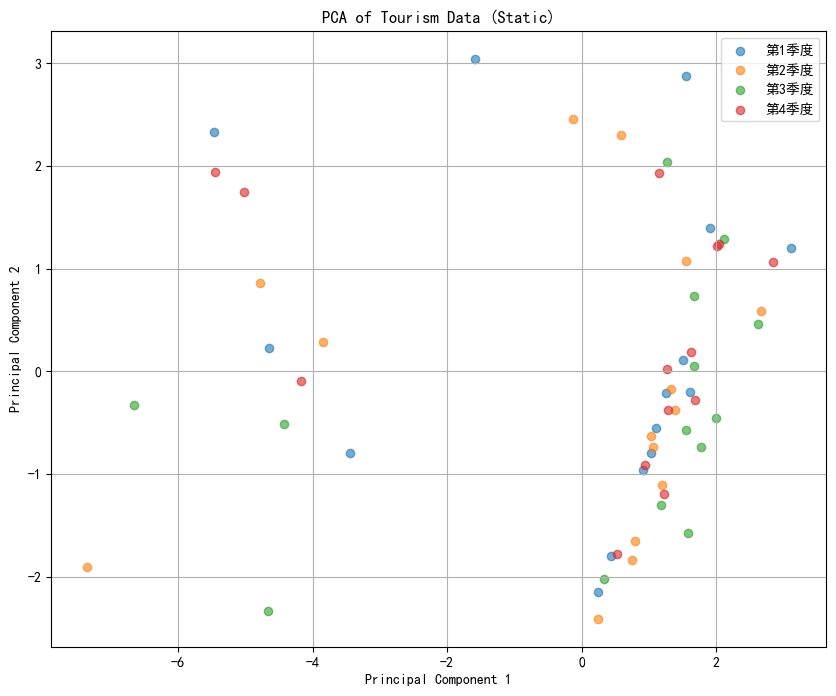

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
import matplotlib.pyplot as plt

# 假设你的DataFrame名称是df
# 选择需要进行PCA的列
columns_to_use = ['旅客总消费', '留宿旅客人均消费', '不过夜旅客人均消费', 
                  '入境旅客', '留宿旅客', '不过夜旅客', '酒店及公寓的平均入住率', 
                  '中国内地个人旅游客', '住客平均留宿时间', '旅客平均逗留时间','release_date']

# 提取需要的列
df_numeric = df[columns_to_use]

# 标准化数据
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_numeric)

# 进行PCA分析
pca = PCA(n_components=2)  # 降维到两个主成分
principal_components = pca.fit_transform(df_standardized)

# 创建包含主成分的DataFrame
df_pca = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# 添加index列用于悬停显示
df_pca['index'] = df.index

# 提取季度信息并添加到df_pca，确保包含“第”和“季度”
df_pca['Quarter'] = df_pca['index'].apply(lambda x: x.split('年')[1].split('季')[0] + '季度')

# 为每个季度分配一个颜色
quarter_colors = {
    '第1季度': 'blue',
    '第2季度': 'green',
    '第3季度': 'red',
    '第4季度': 'orange'
}

# 将颜色添加到df_pca DataFrame中
df_pca['color'] = df_pca['Quarter'].map(quarter_colors)

# 使用Bokeh绘制PCA结果图表并添加悬停工具
output_notebook()

source = ColumnDataSource(data=dict(
    x=df_pca['Principal Component 1'],
    y=df_pca['Principal Component 2'],
    quarter=df_pca['Quarter'],
    index=df_pca['index'],
    color=df_pca['color']  # 添加颜色列到数据源
))

hover = HoverTool(tooltips=[
    ("Index", "@index"),
])

p = figure(width=800, height=600, tools=[hover], title="PCA of Tourism Data")
p.scatter('x', 'y', size=10, source=source, legend_field='quarter', fill_color='color', fill_alpha=0.6)

p.xaxis.axis_label = "Principal Component 1"
p.yaxis.axis_label = "Principal Component 2"

show(p)

# 绘制静态PCA图表
plt.figure(figsize=(10, 8))
for quarter in df_pca['Quarter'].unique():
    subset = df_pca[df_pca['Quarter'] == quarter]
    plt.scatter(subset['Principal Component 1'], subset['Principal Component 2'], label=quarter, alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Tourism Data (Static)')
plt.legend()
plt.grid(True)
plt.show()

**The following is a dynamic interactive UMAP graph and a static UMAP graph, which is more intuitive than PCA. The upper left corner shows the data values during the epidemic period
<br>The dynamic part needs to be reloaded**

D:\Anaconda\Anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Loading BokehJS ...

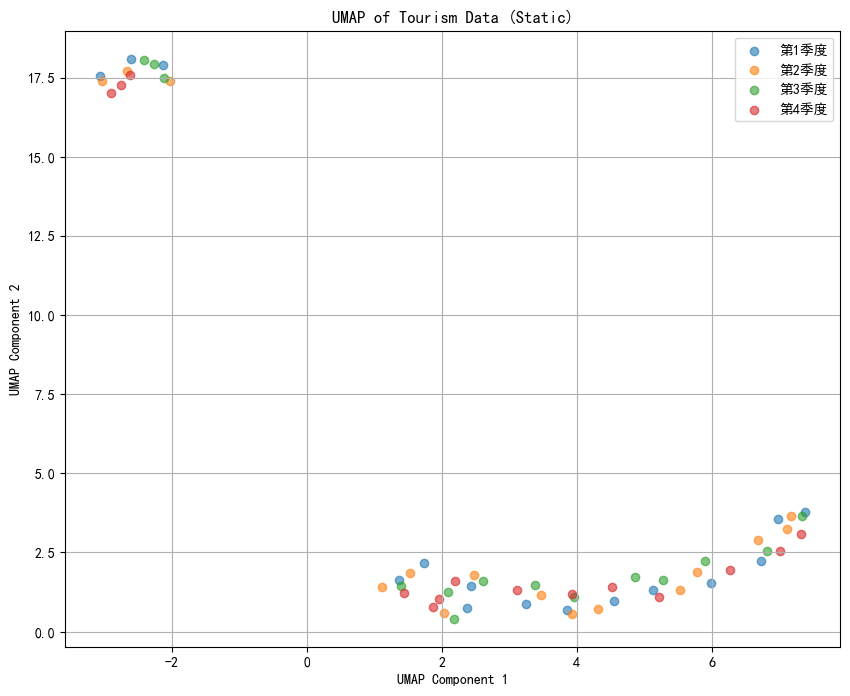

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
import matplotlib.pyplot as plt

# 假设你的DataFrame名称是df
# 选择需要进行UMAP的列
columns_to_use = ['旅客总消费', '留宿旅客人均消费', '不过夜旅客人均消费', 
                  '入境旅客', '留宿旅客', '不过夜旅客', '酒店及公寓的平均入住率', 
                  '中国内地个人旅游客', '住客平均留宿时间', '旅客平均逗留时间','release_date']

# 提取需要的列
df_numeric = df[columns_to_use]

# 标准化数据
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_numeric)

# 进行UMAP分析
umap_model = umap.UMAP(n_components=2, random_state=42)  # 降维到两个主成分
umap_components = umap_model.fit_transform(df_standardized)

# 创建包含UMAP主成分的DataFrame
df_umap = pd.DataFrame(data=umap_components, columns=['UMAP Component 1', 'UMAP Component 2'])

# 添加index列用于悬停显示
df_umap['index'] = df.index

# 提取季度信息并添加到df_umap，确保包含“第”和“季度”
df_umap['Quarter'] = df_umap['index'].apply(lambda x: x.split('年')[1].split('季')[0] + '季度')

# 为每个季度分配一个颜色
quarter_colors = {
    '第1季度': 'blue',
    '第2季度': 'green',
    '第3季度': 'red',
    '第4季度': 'orange'
}

# 将颜色添加到df_umap DataFrame中
df_umap['color'] = df_umap['Quarter'].map(quarter_colors)

# 使用Bokeh绘制UMAP结果图表并添加悬停工具
output_notebook()

source_umap = ColumnDataSource(data=dict(
    x=df_umap['UMAP Component 1'],
    y=df_umap['UMAP Component 2'],
    quarter=df_umap['Quarter'],
    index=df_umap['index'],
    color=df_umap['color']  # 添加颜色列到数据源
))

hover_umap = HoverTool(tooltips=[
    ("Index", "@index"),
    ("Quarter", "@quarter")
])

p_umap = figure(width=800, height=600, tools=[hover_umap], title="UMAP of Tourism Data")
p_umap.scatter('x', 'y', size=10, source=source_umap, legend_field='quarter', fill_color='color', fill_alpha=0.6)

p_umap.xaxis.axis_label = "UMAP Component 1"
p_umap.yaxis.axis_label = "UMAP Component 2"

show(p_umap)

# 绘制静态UMAP图表
plt.figure(figsize=(10, 8))
for quarter in df_umap['Quarter'].unique():
    subset = df_umap[df_umap['Quarter'] == quarter]
    plt.scatter(subset['UMAP Component 1'], subset['UMAP Component 2'], label=quarter, alpha=0.6)

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of Tourism Data (Static)')
plt.legend()
plt.grid(True)
plt.show()

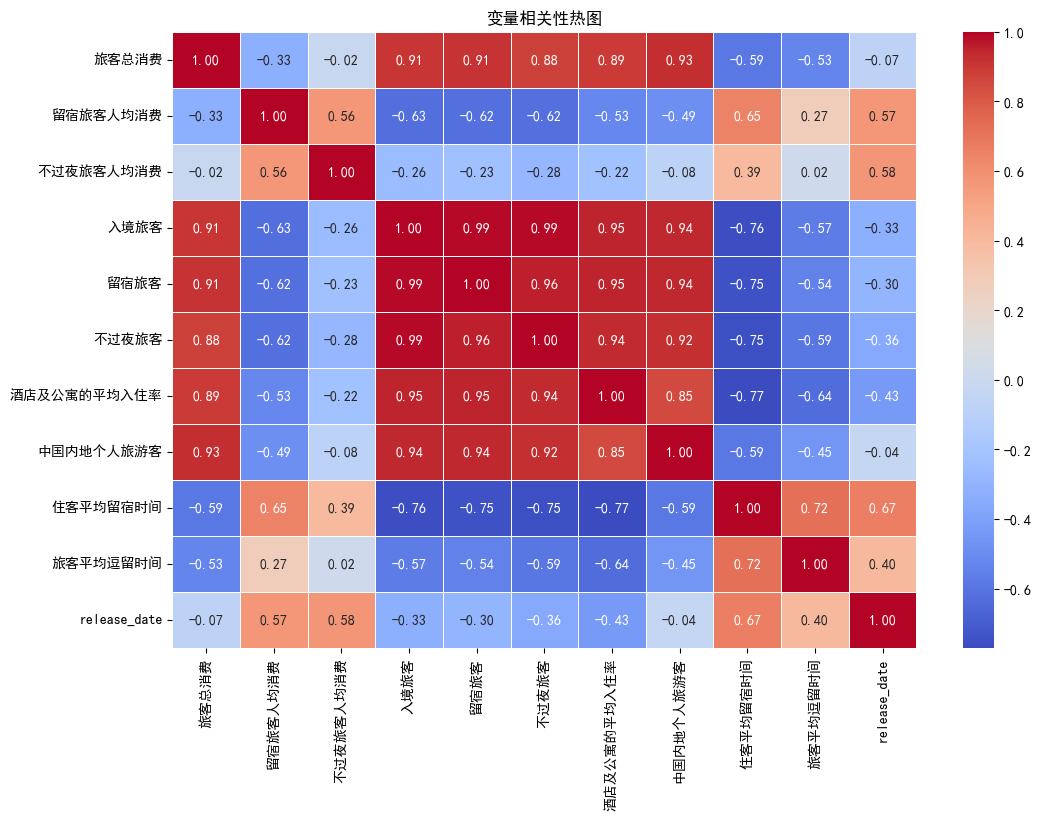

旅客总消费           1.000000
中国内地个人旅游客       0.927970
留宿旅客            0.913024
入境旅客            0.906083
酒店及公寓的平均入住率     0.889991
不过夜旅客           0.880613
不过夜旅客人均消费      -0.022635
release_date   -0.071548
留宿旅客人均消费       -0.330353
旅客平均逗留时间       -0.534014
住客平均留宿时间       -0.587632
Name: 旅客总消费, dtype: float64


In [206]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设你的 DataFrame 名为 df

# 删除 date 列以计算相关性矩阵
df_no_date = df.drop(columns=['date'])

# 计算相关性矩阵
corr_matrix = df_no_date.corr()

# 绘制相关性热图
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('变量相关性热图')
plt.show()

# 特别地，查看目标变量的相关系数
target_corr = corr_matrix['旅客总消费'].sort_values(ascending=False)
print(target_corr)

<h1>Experiments</h1>

Using polynomial regression to create a simple consumption prediction model, the dataset was split into a test set and a validation set, and the results showed that the model's fit was high

In [ ]:
df.to_excel('output.xlsx', index=False)
print("DataFrame has been saved to output.xlsx")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [1047]:

df = pd.read_excel('output.xlsx')
# 假设 df 是您的 DataFrame
X = df.drop(['旅客总消费', 'date'], axis=1)  # 特征变量
y = df['旅客总消费']  # 目标变量

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建一个多项式回归模型，degree参数可以根据需要调整
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# 训练模型
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# 计算R²
r2 = r2_score(y_test, y_pred)
print(f"R² for {'旅客总消费'}: {r2}")

# 计算平均绝对误差
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error for {'旅客总消费'}: {mae}")

# 计算平均绝对百分比误差
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error for {'旅客总消费'}: {mape}%")

Mean Squared Error: 6.317040110111293
R² for 旅客总消费: 1.0
Mean Absolute Error for 旅客总消费: 2.0858194828033447
Mean Absolute Percentage Error for 旅客总消费: 2.4171762598340378e-08%


In [1049]:

# 获取系数和截距
coefficients = model.named_steps['linearregression'].coef_
intercept = model.named_steps['linearregression'].intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [-1.65304243e-06 -1.85992727e-07  6.16074901e-08 -8.58881005e-09
  2.31489126e-08  6.28527091e-09 -2.59358988e-10  1.58200738e-08
 -5.46855829e-10 -2.71747203e-10  8.22950423e-09  4.58264189e-09
  6.13407337e-09  3.33333334e-01  6.66666664e-01 -3.33333330e-01
  2.47973354e-07 -2.25303769e-09  1.19771661e-06  2.91217932e-07
 -1.05919841e-12  7.62001030e-08  3.33333342e-01 -3.33333280e-01
  6.66666622e-01 -2.30506158e-06 -4.05137178e-08 -8.24656066e-08
 -1.78030186e-06 -2.55350401e-13 -7.57346444e-10  1.02873814e-09
  9.82686479e-10  2.14678981e-08 -1.58254671e-10  2.49070114e-10
  2.55073828e-08  3.86366832e-08 -2.71117776e-10 -4.90906693e-10
  2.00714273e-08  1.48859493e-10 -4.87666835e-09  1.75329704e-08
 -3.86367157e-08 -2.29975265e-10  1.39644837e-09  1.62481254e-10
  5.12573741e-09  7.97441168e-09 -3.86366734e-08 -1.02528439e-07
  1.32389174e-08  6.21264837e-09 -6.61682846e-09  1.63266613e-10
  2.76325241e-12  2.80560648e-09  7.40276022e-10  2.78068296e-14
  3.9489515

We are building a new model. Explore the relationship between other features and average and total consumption. degree=1
The results indicate that only total consumption retains a good correlation

In [596]:

# 加载数据
df = pd.read_excel('output.xlsx')

# 定义要选择的列
columns_to_remove = [ 'date','旅客总消费','留宿旅客人均消费', '不过夜旅客人均消费']

# 定义目标列
target_columns = ['旅客总消费','留宿旅客人均消费', '不过夜旅客人均消费']

# 定义一个函数来创建和评估模型
def create_and_evaluate_model_1(df, target_column):
    # 从特征集中去除目标列
    X = df.drop(columns=columns_to_remove + [target_column])
    y = df[target_column]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 创建回归
    model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测测试集
    y_pred = model.predict(X_test)
    
    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for {target_column}: {mse}")
    
    # 计算R²
    r2 = r2_score(y_test, y_pred)
    print(f"R² for {target_column}: {r2}")
    
    # 计算相关系数 r
    r = np.sqrt(r2)
    print(f"Correlation Coefficient (r) for {target_column}: {r}")

    # 计算平均绝对误差
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error for {target_column}: {mae}")
    
    # 计算平均绝对百分比误差
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"Mean Absolute Percentage Error for {target_column}: {mape}%")

# 为每个目标列创建和评估模型
for target_column in target_columns:
    create_and_evaluate_model_1(df, target_column)

Mean Squared Error for 旅客总消费: 2.5291906446090194e+18
R² for 旅客总消费: 0.8476012571336039
Correlation Coefficient (r) for 旅客总消费: 0.9206526256594307
Mean Absolute Error for 旅客总消费: 1425537437.671347
Mean Absolute Percentage Error for 旅客总消费: 14.451596696712542%
Mean Squared Error for 留宿旅客人均消费: 1212366.806276832
R² for 留宿旅客人均消费: 0.5470435800643172
Correlation Coefficient (r) for 留宿旅客人均消费: 0.7396239450317419
Mean Absolute Error for 留宿旅客人均消费: 842.9453652816741
Mean Absolute Percentage Error for 留宿旅客人均消费: 20.133379300981126%
Mean Squared Error for 不过夜旅客人均消费: 17067.918157478856
R² for 不过夜旅客人均消费: 0.44459191036634793
Correlation Coefficient (r) for 不过夜旅客人均消费: 0.6667772569354387
Mean Absolute Error for 不过夜旅客人均消费: 87.40051488984085
Mean Absolute Percentage Error for 不过夜旅客人均消费: 12.06475404668675%


Next, I will attempt to train a model using pre pandemic data to explore the tourism situation in Macau after 2020 under normal circumstances. I found that there are still issues with the model's predictions regarding average consumption

In [689]:

# 加载数据
df = pd.read_excel('output.xlsx')
df = df[df['date'] < '2020-01-01']
# '住客平均留宿时间', '旅客平均逗留时间','留宿旅客','不过夜旅客','酒店及公寓的平均入住率',,'release_date','中国内地个人旅游客'
# 定义要选择的列
columns_to_select = [ '入境旅客','release_date']
# 定义目标列
target_columns = ['旅客总消费','留宿旅客人均消费', '不过夜旅客人均消费']



# 定义一个函数来创建和评估模型
def create_and_evaluate_model_2(df, target_column):
    # 从特征集中去除目标列
    X = df[columns_to_select]
    y = df[target_column]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 创建回归
    model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测测试集
    y_pred = model.predict(X_test)
    
    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for {target_column}: {mse}")
    
    # 计算R²
    r2 = r2_score(y_test, y_pred)
    print(f"R² for {target_column}: {r2}")
    
    # 计算相关系数 r
    r = np.sqrt(r2)
    print(f"Correlation Coefficient (r) for {target_column}: {r}")

    # 计算平均绝对误差
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error for {target_column}: {mae}")
    
    # 计算平均绝对百分比误差
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"Mean Absolute Percentage Error for {target_column}: {mape}%")
    return model


# 为每个目标列创建和评估模型
for target_column in target_columns:
    models[target_column] = create_and_evaluate_model_2(df, target_column)


Mean Squared Error for 旅客总消费: 2.1359162362102152e+18
R² for 旅客总消费: 0.42478174607577246
Correlation Coefficient (r) for 旅客总消费: 0.651752825905475
Mean Absolute Error for 旅客总消费: 1303745153.270359
Mean Absolute Percentage Error for 旅客总消费: 8.775863197060993%
Mean Squared Error for 留宿旅客人均消费: 136255.3080214517
R² for 留宿旅客人均消费: 0.357860081883427
Correlation Coefficient (r) for 留宿旅客人均消费: 0.5982140769686275
Mean Absolute Error for 留宿旅客人均消费: 342.4599108114071
Mean Absolute Percentage Error for 留宿旅客人均消费: 10.688479317728824%
Mean Squared Error for 不过夜旅客人均消费: 2351.6934176440013
R² for 不过夜旅客人均消费: -0.13967105645953892
Correlation Coefficient (r) for 不过夜旅客人均消费: nan
Mean Absolute Error for 不过夜旅客人均消费: 35.58213614723991
Mean Absolute Percentage Error for 不过夜旅客人均消费: 5.0979361261008584%


C:\Users\123\AppData\Local\Temp\ipykernel_15784\3049340800.py:39: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(r2)


So we include average consumption as a characteristic value. Explore the relationship between 'inbound travelers',' release_date ',' per capita consumption of overnight travelers', 'per capita consumption of non overnight travelers' and the total consumption of travelers. The results indicate a good correlation

In [801]:

# 加载数据
df = pd.read_excel('output.xlsx')
df = df[df['date'] < '2020-01-01']
# '住客平均留宿时间', '旅客平均逗留时间','留宿旅客','不过夜旅客','酒店及公寓的平均入住率',,'release_date','中国内地个人旅游客'

columns_to_select = [ '入境旅客','release_date','留宿旅客人均消费', '不过夜旅客人均消费']

# 定义目标列
target_columns = ['旅客总消费']


# 为每个目标列创建和评估模型
for target_column in target_columns:
     models[target_column] = create_and_evaluate_model_2(df, target_column)


Mean Squared Error for 旅客总消费: 2.6225414418830195e+17
R² for 旅客总消费: 0.9293729930289547
Correlation Coefficient (r) for 旅客总消费: 0.9640399333165378
Mean Absolute Error for 旅客总消费: 462491240.8958359
Mean Absolute Percentage Error for 旅客总消费: 3.2197610550267606%


We assume that the average consumption during the epidemic is the average of all previous quarters. So we only need to explore the relationship between dates and inbound travelers.

In [733]:

# 加载数据
df = pd.read_excel('output.xlsx')
# '住客平均留宿时间', '旅客平均逗留时间','留宿旅客','不过夜旅客','酒店及公寓的平均入住率',,'release_date','中国内地个人旅游客'
# 定义要选择的列
columns_to_select = [ '留宿旅客人均消费', '不过夜旅客人均消费','release_date',]

# 定义目标列
target_columns = ['入境旅客']
df = df[df['date'] < '2020-01-01']

models = {}
# 为每个目标列创建和评估模型
for target_column in target_columns:
    models[target_column] = create_and_evaluate_model_2(df, target_column)


Mean Squared Error for 入境旅客: 65550202444.73227
R² for 入境旅客: 0.9278802062572256
Correlation Coefficient (r) for 入境旅客: 0.9632653872413488
Mean Absolute Error for 入境旅客: 208992.75022638869
Mean Absolute Percentage Error for 入境旅客: 2.572441221124344%


Take the average values of "per capita consumption of overnight travelers" and "per capita consumption of non overnight travelers" for each quarter in the dataset before the epidemic, and combine them with the "release_date" after 2020 to predict the number of inbound travelers after 2020

In [981]:

df = pd.read_excel('output.xlsx')

# 确保 'date' 列是 datetime 类型
df['date'] = pd.to_datetime(df['date'])

# 筛选疫情前的数据（2019年之前）
df_pre_covid = df[df['date'] < '2020-01-01']

# 计算每个季度的平均值
quarterly_avg_stay = df_pre_covid.groupby(df_pre_covid['date'].dt.quarter)['留宿旅客人均消费'].mean()
quarterly_avg_non_stay = df_pre_covid.groupby(df_pre_covid['date'].dt.quarter)['不过夜旅客人均消费'].mean()

# 创建一个新的 DataFrame 用于预测2020年之后的数据
df_post_covid = df[df['date'] >= '2020-01-01'].copy()

# 将每个季度的平均值赋给对应的季度
df_post_covid['留宿旅客人均消费'] = df_post_covid['date'].dt.quarter.map(quarterly_avg_stay)
df_post_covid['不过夜旅客人均消费'] = df_post_covid['date'].dt.quarter.map(quarterly_avg_non_stay)

columns_to_select = [ '留宿旅客人均消费', '不过夜旅客人均消费','release_date',]
target_columns = ['入境旅客']
#选择模型
model = models['入境旅客']

# 预测2020年之后的入境人数
X_post_covid = df_post_covid[columns_to_select]
y_pred_post_covid = model.predict(X_post_covid)
# 将预测结果添加到 DataFrame 中
df_post_covid['预测入境旅客'] = y_pred_post_covid

# 输出预测结果
print(df_post_covid[['date', '预测入境旅客']])

         date        预测入境旅客
40 2020-03-31  1.022807e+07
41 2020-06-30  1.054362e+07
42 2020-09-30  1.070929e+07
43 2020-12-31  1.093861e+07
44 2021-03-31  1.094788e+07
45 2021-06-30  1.129492e+07
46 2021-09-30  1.147579e+07
47 2021-12-31  1.171556e+07
48 2022-03-31  1.173243e+07
49 2022-06-30  1.211097e+07
50 2022-09-30  1.230704e+07
51 2022-12-31  1.255726e+07
52 2023-03-31  1.258174e+07
53 2023-06-30  1.299176e+07
54 2023-09-30  1.320304e+07
55 2023-12-31  1.346371e+07
56 2024-03-31  1.349838e+07
57 2024-06-30  1.393998e+07


In [983]:

#选择模型
model = models['旅客总消费']
model_data = df_post_covid.copy()
model_data['入境旅客'] = df_post_covid['预测入境旅客']
# 预测2020年之后的入境人数
columns_to_select = [ '入境旅客','release_date','留宿旅客人均消费', '不过夜旅客人均消费']
X_post_covid = model_data[columns_to_select]
y_pred_post_covid = model.predict(X_post_covid)
# 将预测结果添加到 DataFrame 中
df_post_covid['预测旅客总消费'] = y_pred_post_covid

# 输出预测结果
print(df_post_covid[['旅客总消费', '入境旅客', '预测入境旅客', '预测旅客总消费','date']])


          旅客总消费     入境旅客        预测入境旅客       预测旅客总消费       date
40   5005646823  3219170  1.022807e+07  1.854533e+10 2020-03-31
41     85374779    49730  1.054362e+07  1.811956e+10 2020-06-30
42   1012330667   750204  1.070929e+07  1.829065e+10 2020-09-30
43   5875807932  1877744  1.093861e+07  2.052657e+10 2020-12-31
44   6181394812  1738428  1.094788e+07  1.953210e+10 2021-03-31
45   7161375035  2189401  1.129492e+07  1.893451e+10 2021-06-30
46   4799735622  1827699  1.147579e+07  1.908013e+10 2021-09-30
47   6310619545  1950415  1.171556e+07  2.153505e+10 2021-12-31
48   6595223757  1876847  1.173243e+07  2.042899e+10 2022-03-31
49   3845907464  1588260  1.211097e+07  1.962494e+10 2022-06-30
50   2896118594   898998  1.230704e+07  1.973528e+10 2022-09-30
51   4828388136  1336234  1.255726e+07  2.242580e+10 2022-12-31
52  14976707086  4948358  1.258174e+07  2.119415e+10 2023-03-31
53  17482627731  6697519  1.299176e+07  2.014802e+10 2023-06-30
54  19594696798  8282291  1.320304e+07  

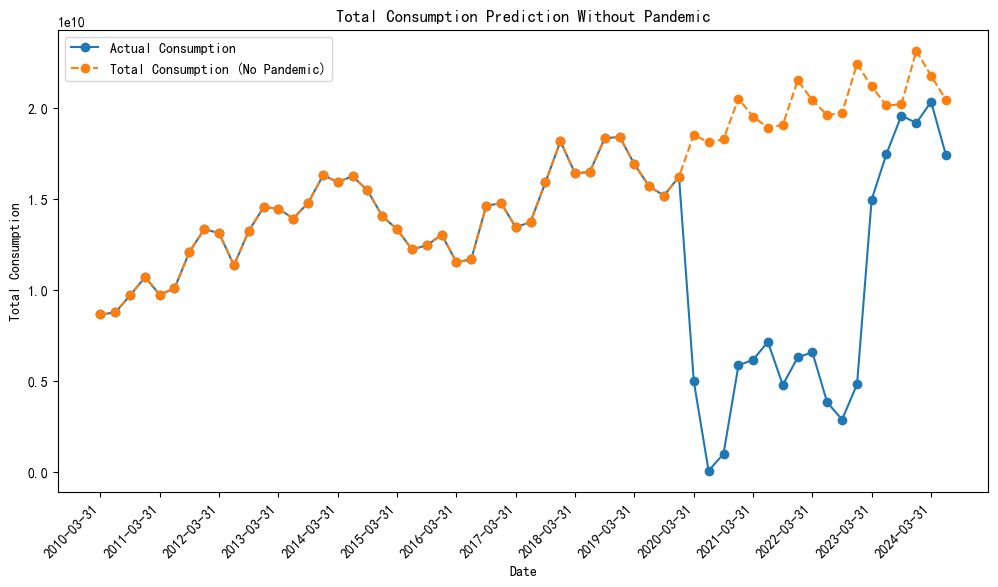

In [1011]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 从Excel文件中加载数据
df = pd.read_excel('output.xlsx')

predicted_df = pd.DataFrame()
predicted_df['旅客总消费'] = df_post_covid['预测旅客总消费']
predicted_df['date'] = df_post_covid['date']  
predicted_df['date'] = predicted_df['date'].dt.date
# 将预测值与原始数据框合并
combined_df = pd.concat([df[(df['date'] < '2020-01-01') ], predicted_df])


# combined_df = combined_df.sort_values(by='date').reset_index(drop=True)
# 确保 'date' 列是 datetime 类型
df['date'] = pd.to_datetime(df['date'])
combined_df['date'] = pd.to_datetime(combined_df['date'])

# 绘制实际和预测值的折线图
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['旅客总消费'], label='Actual Consumption',marker='o')
plt.plot(combined_df['date'], combined_df['旅客总消费'], label='Total Consumption (No Pandemic)', linestyle='--', marker='o')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.xticks(df['date'][::4], rotation=45, ha='right')  # X轴设置间隔为三个季度
plt.title('Total Consumption Prediction Without Pandemic')
plt.legend()
plt.show()